In [3]:
import numpy as np
import pandas as pd


In [4]:
df=pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

In [9]:


df.shape

(1462, 9)

In [10]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [12]:
missing_values = df.isnull().sum()
print(missing_values)

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64


In [13]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [15]:
# Remove the y vairable
numerical_cols.remove('converted')

In [16]:
# For categorical features, replace with 'NA'
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna('NA')
        print(f"Filled {col} with 'NA'")

# For numerical features, replace with 0.0
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(0.0)
        print(f"Filled {col} with 0.0")

Filled lead_source with 'NA'
Filled industry with 'NA'
Filled employment_status with 'NA'
Filled location with 'NA'
Filled annual_income with 0.0


In [26]:
# Separate features and target
X = df.drop('converted', axis=1)
y = df['converted']

In [110]:
from sklearn.model_selection import train_test_split
full_train_df,test_df = train_test_split(df,test_size=0.2,random_state=1)
train_df,val_df = train_test_split(full_train_df,test_size=0.25,random_state=1)

In [111]:
len(full_train_df),len(train_df),len(test_df),len(val_df)

(1169, 876, 293, 293)

In [112]:
train_df.reset_index(drop=True, inplace = True)
val_df.reset_index(drop=True, inplace = True)
test_df.reset_index(drop=True, inplace = True)
full_train_df.reset_index(drop=True,inplace=True)

In [113]:
y_train = train_df.converted.values
y_val = val_df.converted.values
y_test = test_df.converted.values
y_full_train = full_train_df.converted.values

In [23]:
del train_df["converted"]
del val_df["converted"]
del test_df["converted"]
del full_train_df["converted"]

In [114]:
from sklearn.metrics import roc_auc_score
# Target
y_train = train_df['converted']

# Numerical variables to test
numerical_vars = [
    'lead_score',
    'number_of_courses_viewed',
    'interaction_count',
    'annual_income'
]

# Compute AUC for each
for col in numerical_vars:
    auc = roc_auc_score(y_train, train_df[col])
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -train_df[col])
    
    print(f"{col}: {auc:.3f}")

lead_score: 0.614
number_of_courses_viewed: 0.764
interaction_count: 0.738
annual_income: 0.552


In [115]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
y_train = train_df['converted']
y_val = val_df['converted']
train_dict = train_df.drop('converted', axis=1).to_dict(orient='records')
val_dict = val_df.drop('converted', axis=1).to_dict(orient='records')

In [118]:
dv = DictVectorizer(sparse=False)
# Scale numeric features
scaler = StandardScaler()
numerical = train_df.select_dtypes(include=['number']).columns.tolist()
numerical.remove('converted')  # remove target column
#X_train = scaler.fit_transform(train_dict)
#X_val = scaler.transform(val_dict)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=10000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=10000, solver='liblinear')

In [117]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# 1️⃣ Select only numeric columns
numerical = train_df.select_dtypes(include=['number']).columns.tolist()
numerical.remove('converted')  # remove target

# 2️⃣ Extract numeric data
X_train = train_df[numerical]
X_val = val_df[numerical]

# 3️⃣ Extract targets
y_train = train_df['converted']
y_val = val_df['converted']

# 4️⃣ Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 5️⃣ Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_scaled, y_train)

# 6️⃣ Evaluate on validation data
y_pred = model.predict_proba(X_val_scaled)[:, 1]
auc = roc_auc_score(y_val, y_pred)

print(f"Validation AUC: {auc:.3f}")


Validation AUC: 0.884


In [119]:
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"Validation AUC: {auc:.3f}")


Validation AUC: 0.817


In [120]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

In [121]:
y_val = val_df['converted']
y_pred = model.predict_proba(X_val)[:, 1]

In [122]:
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []

for t in thresholds:
    y_pred_t = (y_pred >= t)
    precisions.append(precision_score(y_val, y_pred_t))
    recalls.append(recall_score(y_val, y_pred_t))


/Users/zayesosa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zayesosa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zayesosa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


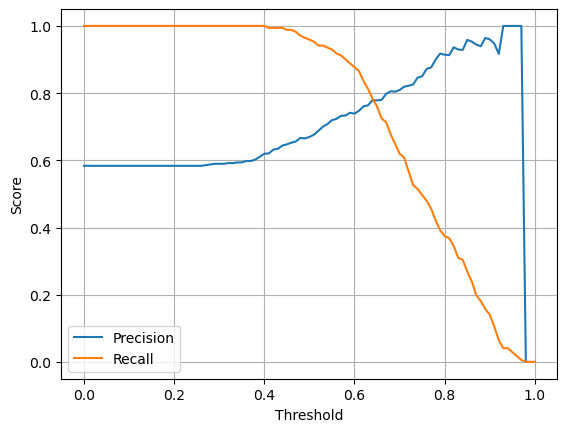

In [123]:
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [124]:

thresholds = np.linspace(0, 1, 101)
diff = np.abs(np.array(precisions) - np.array(recalls))

# Find where the difference is minimal (close enough to equal)
intersection_indices = np.where(diff < 0.005)[0]

# Get corresponding thresholds
intersection_thresholds = thresholds[intersection_indices]

# Round to 5 significant figures
intersection_thresholds = [float(f"{t:.5g}") for t in intersection_thresholds]
intersection_thresholds

[0.64, 0.98, 0.99, 1.0]

In [125]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0, 1, 101)

f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_pred >= t).astype(int)
    p = precision_score(y_val, y_pred_thresh)
    r = recall_score(y_val, y_pred_thresh)
    if (p + r) == 0:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1 score: {best_f1:.3f}")


Best threshold: 0.570
Best F1 score: 0.812


/Users/zayesosa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zayesosa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zayesosa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [127]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import numpy as np

# Prepare dataset
df_full_train = df.copy()
y = df_full_train.converted.values

categorical = df_full_train.select_dtypes(include=['object']).columns.tolist()
numerical = df_full_train.select_dtypes(include=['number']).columns.tolist()
numerical.remove('converted')

# KFold setup
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    train_dict = df_train[categorical + numerical].to_dict(orient='records')
    val_dict = df_val[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print("AUC scores for each fold:", np.round(scores, 3))
print("Mean AUC:", np.mean(scores))
print("Std of AUC:", np.std(scores))


AUC scores for each fold: [0.817 0.779 0.831 0.868 0.809]
Mean AUC: 0.8208745760125474
Std of AUC: 0.028845510405609943


In [128]:
C_values = [0.000001, 0.001, 1]
results = []

for C in C_values:
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        train_dict = df_train[categorical + numerical].to_dict(orient='records')
        val_dict = df_val[categorical + numerical].to_dict(orient='records')

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    results.append((C, round(mean_auc, 3), round(std_auc, 3)))

# Display results
for C, mean_auc, std_auc in results:
    print(f"C={C:<9} Mean AUC={mean_auc}, Std={std_auc}")

# Select best C
best = max(results, key=lambda x: (x[1], -x[2], -x[0]))
print(f"\n✅ Best C: {best[0]} (Mean AUC={best[1]}, Std={best[2]})")


C=1e-06     Mean AUC=0.549, Std=0.03
C=0.001     Mean AUC=0.862, Std=0.024
C=1         Mean AUC=0.821, Std=0.029

✅ Best C: 0.001 (Mean AUC=0.862, Std=0.024)
